The following notebook introduces ML-Ensemble, a Python library for memory-efficient parallel ensemble learning with a Scikit-learn API. 

ML-Ensemble also deploys a neural network-like API for building ensembles of several layers, and can accomodate a great variety of ensemble architectures. 

For more information, see http://mlens.readthedocs.io/en/latest/index.html.

In [1]:
import gc
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Inputs
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

# Data viz
from mlens.visualization import corr_X_y, corrmat

# Model evaluation
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
from mlens.preprocessing import EnsembleTransformer

# Ensemble
from mlens.ensemble import SuperLearner

from scipy.stats import uniform, randint

from matplotlib.pyplot import show
%matplotlib inline

In [2]:
SEED = 148
np.random.seed(SEED)

# 1. Getting a good baseline for ensemble learning

It's always good to check how inputs play along with the output.
Here, we highlight one example functionality of the Ml-Ensemble's
visualization library.

In [3]:
from datetime import datetime
def write_file(p_test):
    print("Start write result ...")
    sub = pd.read_csv('sample_submission.csv')
    for c in sub.columns[sub.columns != 'ParcelId']:
        sub[c] = p_test

    sub.to_csv('ML_Stacking_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False, float_format='%.4f')
    print ('Done!')

def build_train(drop_outlier=True):
    """Read in training data and return input, output, columns tuple."""

    # This is a version of Anovas minimally prepared dataset
    # for the xgbstarter script
    # https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655

    df = pd.read_csv('train_2016_v2.csv')

    prop = pd.read_csv('properties_2016.csv')
    convert = prop.dtypes == 'float64'
    prop.loc[:, convert] = \
        prop.loc[:, convert].apply(lambda x: x.astype(np.float32))

    df = df.merge(prop, how='left', on='parcelid')
    if drop_outlier:
        df = df[df.logerror>-0.4]
        df = df[df.logerror<0.418]

    y = df.logerror
    df = df.drop(['parcelid',
                  'logerror',
                  'transactiondate',
                  'propertyzoningdesc',
                  'taxdelinquencyflag',
                  'propertycountylandusecode'], axis=1)

    convert = df.dtypes == 'object'
    df.loc[:, convert] = \
        df.loc[:, convert].apply(lambda x: 1 * (x == True))

    df.fillna(0, inplace=True)

    return df, y, df.columns

In [4]:
x_train, y_train, columns = build_train()
xtrain, xval, ytrain, yval = train_test_split(x_train,
                                                y_train,
                                                test_size=0.9,
                                                random_state=SEED)

/home/mikegao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
sample=pd.read_csv('sample_submission.csv')
prop = pd.read_csv('properties_2016.csv')
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

del prop; gc.collect()

xtest = df_test[columns]
for c in xtest.dtypes[xtest.dtypes == object].index.values:
    xtest[c] = (xtest[c] == True)
xtest.fillna(0, inplace=True)

/home/mikegao/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mikegao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/mikegao/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


/home/mikegao/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


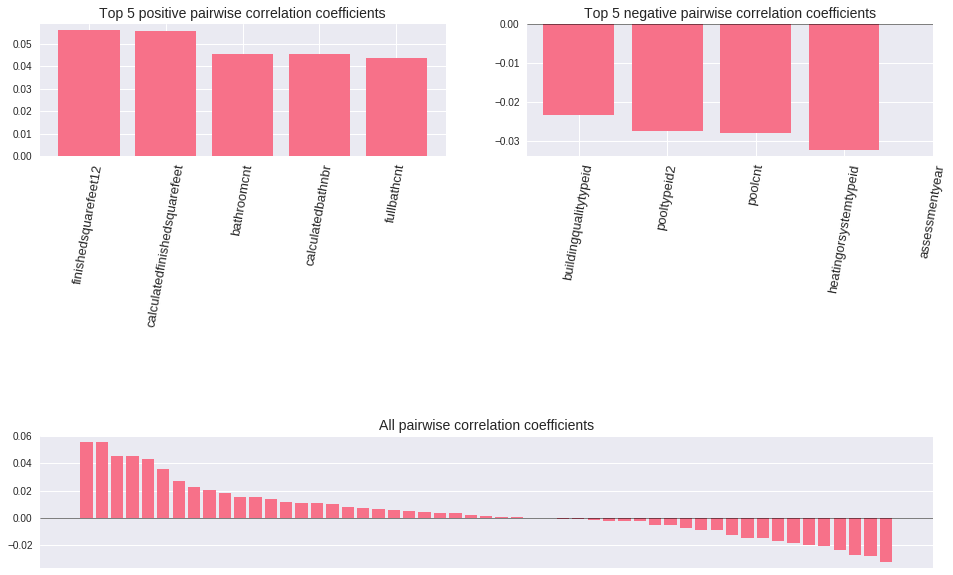

In [6]:
# this plot requires mlens 0.1.3, Kaggle is currently on 0.1.2
corr_X_y(xtrain, ytrain, figsize=(16, 10), label_rotation=80, hspace=1, fontsize=14)

A few features seems to be (first-order) uncorrelated with the output, suggesting estimators with inherent
feature selection should be preferred.

Now, consider how set of base learners (estimators) perform as they are.

In [7]:
# We consider the following models (or base learners)
gb = XGBRegressor(n_jobs=1, random_state=SEED)
ls = Lasso(alpha=1e-6, normalize=True)
el = ElasticNet(alpha=1e-6, normalize=True)
rf = RandomForestRegressor(random_state=SEED)
ex = ExtraTreesRegressor(random_state=SEED)
ada = AdaBoostRegressor(random_state=SEED)
lgb = LGBMRegressor(objective='regression', nthread=1,seed=SEED)

base_learners = [('ls', ls),
                #('el', el),
                 ('rf', rf),
                 ('ex', ex),
                 #('ada', ada),
                 ('gb', gb),
                 ('lgb', lgb)
                ]

In [8]:
P = np.zeros((xval.shape[0], len(base_learners)))
P = pd.DataFrame(P, columns=[e for e, _ in base_learners])

for est_name, est in base_learners:
    est.fit(xtrain, ytrain)
    p = est.predict(xval)
    P.loc[:, est_name] = p
    print("%3s : %.4f" % (est_name, mean_absolute_error(yval, p)))

 ls : 0.0533
 rf : 0.0598
 ex : 0.0610
 gb : 0.0534
lgb : 0.0533


So they all score relatively close. However, they seem to capture different aspects of the feature space, as shown by the low correlation of their predictions:

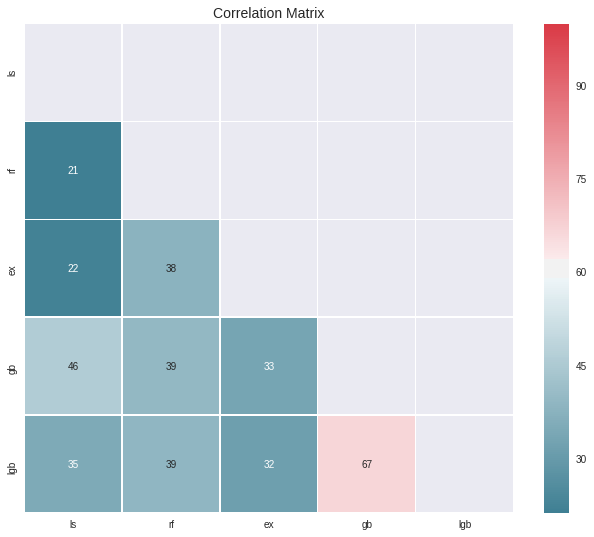

In [9]:
ax = corrmat(P.corr())
show()

They are in fact not particularly correlated in their scoring (except the linear models), and hence
an ensemble may be able to outperform any single model by learning to combine their respective strength.

## 2. Comparing base learners

*emphasized text*To facilitate base learner comparison, ML-Ensemble implements a randomized grid search
class that allows specification of several estimators (and preprocessing pipelines) in
one grid search.

In [10]:
# Put their parameter dictionaries in a dictionary with the
# estimator names as keys
param_dicts = {'ls':
                  {'alpha': uniform(1e-6, 1e-5)},
               #'el':
               #   {'alpha': uniform(1e-6, 1e-5),
               #    'l1_ratio': uniform(0, 1)},
               'ex':
                   {'n_estimators': randint(50,150),
                    'max_depth': randint(1,10)},
               #'ada':
               #    {'learning_rate': uniform(0.02, 0.04),
               #     'n_estimators': randint(50,150)},
               'gb':
                   {'learning_rate': uniform(0.02, 0.04),
                    'colsample_bytree': uniform(0.55, 0.66),
                    'min_child_weight': randint(30, 60),
                    'max_depth': randint(3, 7),
                    'subsample': uniform(0.4, 0.2),
                    'n_estimators': randint(150, 200),
                    'colsample_bytree': uniform(0.6, 0.4),
                    'reg_lambda': uniform(1, 2),
                    'reg_alpha': uniform(1, 2),
                   },
               'rf':
                   {'max_depth': randint(2, 5),
                    'min_samples_split': randint(5, 20),
                    'min_samples_leaf': randint(10, 20),
                    'n_estimators': randint(50, 100),
                    'max_features': uniform(0.6, 0.3)},
               
               'lgb':
                  {'learning_rate': uniform(0.02,0.04),
                   'num_leaves': randint(50, 60),
                   'n_estimators': randint(150,200),
                   'max_bin': randint(250,500),
                   'min_child_weight': randint(30,60),
                    'colsample_bytree': randint(1,10),
                    'reg_alpha': uniform(0,0.5),
                    'reg_lambda': uniform(0,0.5)
                   }
              }

In [11]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

evl = Evaluator(scorer,
                cv=5,
                random_state=SEED,
                verbose=5,
                backend='threading',
                n_jobs=1
               )

In [12]:
evl.fit(xtrain.values,  # you can pass DataFrames from mlens>=0.1.3 
        ytrain.values,
        estimators=base_learners,
        param_dicts=param_dicts,
        preprocessing={'sc': [StandardScaler()], 'none': []},
        n_iter=20)  # bump this up to do a larger grid search

Preprocessing 2 preprocessing pipelines over 5 CV folds
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
Preprocessing done | 00:00:00

/home/mikegao/anaconda3/lib/python3.6/site-packages/mlens/model_selection/model_selection.py:484: UserWarning: No valid parameters found for ('sc', 'lgb'). Will fit and score once with given parameter settings.
  "settings.".format(key))
/home/mikegao/anaconda3/lib/python3.6/site-packages/mlens/model_selection/model_selection.py:484: UserWarning: No valid parameters found for ('none', 'lgb'). Will fit and score once with given parameter settings.
  "settings.".format(key))
Evaluating 10 models for 20 parameter draws o

In [13]:
pd.DataFrame(evl.summary)

test_score_mean  test_score_std  train_score_mean  train_score_std  \
none ex         -0.052545        0.001070         -0.052252         0.000244   
     gb         -0.052375        0.000983         -0.051534         0.000202   
     lgb        -0.052730        0.000988         -0.050576         0.000222   
     ls         -0.052351        0.001044         -0.052174         0.000237   
     rf         -0.052449        0.000931         -0.051694         0.000195   
sc   ex         -0.052545        0.001070         -0.052252         0.000244   
     gb         -0.052364        0.000979         -0.051528         0.000208   
     lgb        -0.052695        0.000952         -0.050575         0.000222   
     ls         -0.052351        0.001044         -0.052174         0.000237   
     rf         -0.052450        0.000932         -0.051694         0.000195   

          fit_time_mean  fit_time_std  \
none ex        0.504063      0.007718   
     gb        0.836706      0.010416   
     lgb       0.037247      0.000725   
     ls        0.008979      0.001551   
     rf        0.942659      0.025366   
sc   ex        0.489169      0.002496   
     gb        0.830372      0.010147   
     lgb       0.046434      0.001384   
     ls        0.008674      0.001960   
     rf        0.926741      0.012818   

                                                     params  
none ex               {'n_estimators': 131, 'max_depth': 3}  
     gb   {'learning_rate': 0.044636919535, 'colsample_b...  
     lgb                                                 {}  
     ls                        {'alpha': 8.12960418991e-06}  
     rf   {'max_depth': 4, 'min_samples_split': 11, 'min...  
sc   ex               {'n_estimators': 131, 'max_depth': 3}  
     gb   {'learning_rate': 0.044636919535, 'colsample_b...  
     lgb                                                 {}  
     ls                        {'alpha': 8.12960418991e-06}  
     rf   {'max_depth': 4, 'min_samples_split': 11, 'min...

There you have it, a comparison of tuned models in one grid search!

Optimal parameters are then easily accessed.

In [14]:
evl.summary["params"][('sc', 'gb')]

{'colsample_bytree': 0.84636919535030053,
 'learning_rate': 0.044636919535030059,
 'max_depth': 3,
 'min_child_weight': 36,
 'n_estimators': 166,
 'reg_alpha': 2.2318459767515026,
 'reg_lambda': 2.2318459767515026,
 'subsample': 0.52318459767515035}

# 3. Comparing meta learners

Running an entire ensemble several times just to compare different meta learners can be prohibitvely expensive. ML-Ensemble implements a class that acts as a transformer, allowing you to use ingoing layers as a "preprocessing" step, so that you need only evaluate the meta learners iteratively.

In [15]:
for case_name, params in evl.summary["params"].items():
    for est_name, est in base_learners:
        if est_name == case_name[1]:
            est.set_params(**params)

In [16]:
# We will compare a GBM and an elastic net as the meta learner
# These are cloned internally so we can go ahead and grab the fitted ones
meta_learners = [('gb', gb),
                 ('el', el)]

# Note that when we have a preprocessing pipeline,
# keys are in the (prep_name, est_name) format
param_dicts = {'el':
                  {'alpha': uniform(1e-5, 1),
                   'l1_ratio': uniform(0, 1)},
               'gb':
                   {'learning_rate': uniform(0.01, 0.2),
                    'subsample': uniform(0.5, 0.5),
                    'reg_lambda': uniform(0.1, 1),
                    'n_estimators': randint(10, 100)},
              }

In [17]:
# Here, we but the base learners in an EnsembleTransformer class
# this class will faithfully reproduce predictions for each fold
# in a cross-validation execution as if it was the first n layers
# of an ensemble

# The API of the Ensemble transformer mirrors that of the SequentialEnsemble class,
# see documentation for further info
in_layer = EnsembleTransformer()
in_layer.add('stack', base_learners)

preprocess = [in_layer]

In [ ]:
evl.fit(xtrain.values,
        ytrain.values,
        meta_learners,
        param_dicts,
        preprocessing={'meta': preprocess},
        n_iter=20                            # bump this up to do a larger grid search
       )

Preprocessing 1 preprocessing pipelines over 5 CV folds


In [19]:
pd.DataFrame(evl.summary)

test_score_mean  test_score_std  train_score_mean  train_score_std  \
meta el        -0.052685        0.001059         -0.052681         0.000260   
     gb        -0.052533        0.001017         -0.052205         0.000265   

         fit_time_mean  fit_time_std  \
meta el       0.000530      0.000015   
     gb       0.039732      0.001122   

                                                    params  
meta el  {'alpha': 0.575415852231, 'l1_ratio': 0.575405...  
     gb  {'learning_rate': 0.123474273812, 'subsample':...

# 4. Ensemble learning

With these results in mind, we now turn to building an ensemble estimator.

ML-Ensemble uses a neural network-like API to specify layers of base learners to be
fitted sequentially on the previous layer's predictions (or the raw input for the
first layer). An ensemble is built as a Scikit-learn estimator, and can be used as
any other Scikit-learn class.

In [20]:
# Let's pick the linear meta learner with the above tuned
# hyper-parameters. Note that ideally, you'd want to tune
# the ensemble as a whole, not each estimator at a time
meta_learner = meta_learners[1][1]

meta_learner.set_params(**evl.summary["params"][("meta", "el")])

ElasticNet(alpha=0.57541585223123481, copy_X=True, fit_intercept=True,
      l1_ratio=0.57540585223123486, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

The ensemble we will implement is the Super Learner, also known as a stacking ensemble. There are several alternatives, see the documentation for further info.

In [21]:
# Instantiate the ensemble by adding layers to it. Finalize with a meta layer
ens = SuperLearner(verbose=5,
                   backend="threading") # mlens can release the GIL
ens.add(base_learners)
ens.add_meta(meta_learner)

SuperLearner(array_check=2, backend='threading', folds=2,
       layers=LayerContainer(backend='threading',
        layers=OrderedDict([('layer-1', Layer(cls='stack', cls_kwargs=None, dtype=<class 'numpy.float32'>,
   estimators=[('ls', Lasso(alpha=8.1296041899066758e-06, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precomput...xception=True, scorer=None,
   verbose=5))]),
        n_jobs=-1, raise_on_exception=True, verbose=5),
       n_jobs=-1, raise_on_exception=True, random_state=None, scorer=None,
       shuffle=False, verbose=5)

Once instantiated, the ensemble will behave like any other Scikit-learn estimator.

In [22]:
ens.fit(xtrain, ytrain)


Fitting 2 layers

Processing layer-1
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.8s finished
layer-1 Done | 00:00:01

Processing layer-2
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
layer-2 Done | 00:00:00

Fit complete | 00:00:01



SuperLearner(array_check=2, backend='threading', folds=2,
       layers=LayerContainer(backend='threading',
        layers=OrderedDict([('layer-1', Layer(cls='stack', cls_kwargs=None, dtype=<class 'numpy.float32'>,
   estimators=[('ls', Lasso(alpha=8.1296041899066758e-06, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precomput...xception=True, scorer=None,
   verbose=5))]),
        n_jobs=-1, raise_on_exception=True, verbose=5),
       n_jobs=-1, raise_on_exception=True, random_state=None, scorer=None,
       shuffle=False, verbose=5)

Predictions are generated as usual:

In [23]:
pred = ens.predict(xtest)


Predicting with 2 layers

Processing layer-1
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.3s finished
layer-1 Done | 00:00:05

Processing layer-2
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
layer-2 Done | 00:00:00

Prediction complete | 00:00:05



In [24]:
write_file(pred)

Start write result ...
Done!


In [ ]:
print("ensemble score: %.4f" % mean_absolute_error(ytest, pred))

And that's it for this tutorial!

You might have noticed that the ensemble did not achieve an increase in performance. This is partly due to the lack of proper hyper parameter tuning, but more importantly because the base learners are not sufficiently accurate for there to be anything meaningful for the meta learner to learn from (note that predicting the average gets you about 0.07) 

In these cases, unless the meta learner is underfitting, the ensemble will at least be on par with the best base learner.  Good features are always the primary source of predictive power. Once you have them, combining different estimators in an ensemble is a powerful way of learning as much of the signal in the data as possible.

If you decide to give ML-Ensemble a try, note that the library is in beta testing so you may run into some unexpected behavior or see opportunities for improvements. Feel free to contribute to the project via the [github](https://github.com/flennerhag/mlens) repository! 